# YOLOv8 two-class (transformer, breaker) on Colab
This notebook installs Ultralytics, ingests the `yolo_sld_2` dataset from a zip upload, trains on GPU, and exports weights.

In [4]:
# 1) Install Ultralytics (CUDA on Colab)
!pip install -q ultralytics==8.3.230
import ultralytics
ultralytics.checks()

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.0/235.7 GB disk)


## Upload dataset zip
From your local machine, zip the reduced dataset (`yolo_sld_2`) and upload it. Example locally:
```
zip -r yolo_sld_2.zip yolo_sld_2
```
Then run the next cell and choose the zip.

In [ ]:
from google.colab import files
import zipfile, io, os

uploaded = files.upload()
zip_name = list(uploaded.keys())[0]
print("Received", zip_name)

with zipfile.ZipFile(io.BytesIO(uploaded[zip_name])) as z:
    z.extractall("/")

os.listdir('/content')

Saving yolo_sld_2.zip to yolo_sld_2 (1).zip
Received yolo_sld_2 (1).zip


['.config', 'yolo_sld_2 (1).zip', 'yolo_sld_2.zip']

In [ ]:
import os, zipfile

zip_path = "/content/yolo_sld_2 (1).zip"  # adjust if the name differs
with zipfile.ZipFile(zip_path) as z:
      z.extractall("/content")

print("Top-level after unzip:", os.listdir("/content"))
print("yolo_sld_2 exists?", os.path.isdir("/content/yolo_sld_2"))


Top-level after unzip: ['.config', 'yolo_sld_2 (1).zip', '__MACOSX', 'yolo_sld_2.zip', 'yolo_sld_2']
yolo_sld_2 exists? True


## (Optional) Check balance
Quick sanity check of class counts.

In [2]:
from pathlib import Path
from collections import Counter, defaultdict
import yaml

data_path = Path('/content/drive/MyDrive/yolo_sld_2/data.yaml')
with open(data_path) as f:
    cfg = yaml.safe_load(f)
names = cfg['names'] if isinstance(cfg['names'], list) else [cfg['names'][k] for k in sorted(cfg['names'])]

def load_counts(split):
    lbl_dir = data_path.parent / 'labels' / split
    counts = Counter()
    imgs = 0
    if lbl_dir.exists():
        for f in lbl_dir.glob('*.txt'):
            imgs += 1
            with open(f) as fh:
                for line in fh:
                    parts = line.strip().split()
                    if parts:
                        counts[int(parts[0])] += 1
    return imgs, counts

for split in ['train','val','test']:
    imgs, counts = load_counts(split)
    print(split, 'images', imgs, 'boxes', sum(counts.values()), {names[i]: counts[i] for i in counts})

train images 3309 boxes 10435 {'transformer': 5313, 'breaker': 5122}
val images 1102 boxes 3445 {'transformer': 1743, 'breaker': 1702}
test images 1102 boxes 3371 {'transformer': 1662, 'breaker': 1709}


## Train
Adjust `epochs`, `imgsz`, `batch` as needed. Colab T4/L4 should handle `yolov8s` at 1024 with batch 8–16. Reduce if OOM.

In [8]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')
result = model.train(
    data=str(data_path),
    imgsz=1024,
    epochs=50,
    batch=16,
    device=0,
    workers=8,
    name='yolo_2class_colab'
)
result

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_sld_2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_2class_colab, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

RuntimeError: Dataset '/content/drive/MyDrive/yolo_sld_2/data.yaml' error ❌ Dataset '/content/drive/MyDrive/yolo_sld_2/data.yaml' images not found, missing path '/content/datasets/yolo_sld_2/images/val'
Note dataset download directory is '/content/datasets'. You can update this in '/root/.config/Ultralytics/settings.json'

In [ ]:
model = YOLO("yolov8s.pt")
result_big = model.train(
    data=str(data_path),
    imgsz=1280,
    epochs=120,
    batch=16,
    device=0,
    workers=8,
    name='yolo_2class_a100_aug',
    mosaic=1.0,
    mixup=0.1,
    copy_paste=0.1,
    cos_lr=True,
    close_mosaic=10
)
result_big

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_sld_2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_2class_a100_aug, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3e1a4cbfe0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [9]:
%%writefile /content/drive/MyDrive/yolo_sld_2/data.yaml
path: /content/drive/MyDrive/yolo_sld_2

train: /content/drive/MyDrive/yolo_sld_2/images/train
val: /content/drive/MyDrive/yolo_sld_2/images/val
test: /content/drive/MyDrive/yolo_sld_2/images/test

names:
  0: transformer
  1: breaker


Overwriting /content/drive/MyDrive/yolo_sld_2/data.yaml


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')  # or yolov8l.pt
model.train(
    data='/content/drive/MyDrive/yolo_sld_2/data.yaml',
    imgsz=1408,
    epochs=180,
    batch=4,     # raise if VRAM allows
    device=0,
    mosaic=1.0,
    mixup=0.1,
    amp=False,
    copy_paste=0.1,
    cos_lr=True,
    close_mosaic=10,
    name='yolo_2class_m1408'
  )

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/yolo_sld_2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=180, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1408, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_2class_m14088, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

## Validate / Test

In [ ]:
best = model.ckpt_path if hasattr(model, 'ckpt_path') else model.trainer.best
print('Best weights:', best)
metrics = model.val(data=str(data_path), imgsz=1024, batch=16, device=0, split='test')
metrics

Best weights: yolov8s.pt
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2062.0±1183.8 MB/s, size: 118.3 KB)
val: Scanning /content/yolo_sld_2/labels/test.cache... 1102 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1102/1102 2.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 8.0it/s 8.6s
                   all       1102       3371      0.888      0.576      0.694      0.536
           transformer        889       1662      0.894      0.573      0.687      0.519
               breaker        895       1709      0.881      0.578      0.701      0.554
Speed: 1.4ms preprocess, 2.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/runs/detect/val2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3e19f18800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## Export and download weights

In [ ]:
export_path = model.export(format='torchscript', device=0)
print('Exported to', export_path)
from google.colab import files
files.download(export_path)

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/yolo_2class_colab/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 6, 21504) (21.5 MB)

TorchScript: starting export with torch 2.9.0+cu126...
TorchScript: export success ✅ 1.3s, saved as '/content/runs/detect/yolo_2class_colab/weights/best.torchscript' (43.0 MB)

Export complete (1.4s)
Results saved to /content/runs/detect/yolo_2class_colab/weights
Predict:         yolo predict task=detect model=/content/runs/detect/yolo_2class_colab/weights/best.torchscript imgsz=1024  
Validate:        yolo val task=detect model=/content/runs/detect/yolo_2class_colab/weights/best.torchscript imgsz=1024 data=/content/yolo_sld_2/data.yaml  
Visualize:       https://netron.app
Exported to /c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!yolo detect predict \
      model=/content/runs/detect/yolo_2class_a100_aug/weights/best.pt \
      source=/content/One-Line-Sample.png \
      imgsz=1280 \
      conf=0.25 \
      save=True \
      save_txt=True

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/One-Line-Sample.png: 832x1280 10 transformers, 4 breakers, 73.9ms
Speed: 10.7ms preprocess, 73.9ms inference, 7.6ms postprocess per image at shape (1, 3, 832, 1280)
Results saved to /content/runs/detect/predict
1 label saved to /content/runs/detect/predict/labels
💡 Learn more at https://docs.ultralytics.com/modes/predict


## Predict with tiling (for large SLDs)
  Tiles the SLD to reduce duplicate/overlapping detections, runs prediction on tiles, and lists outputs.

  Code (tile + predict):

In [ ]:

from pathlib import Path
import shutil, subprocess, os
from IPython.display import Image, display

source_img = '/content/One-Line-Sample.png'  # change if needed
tile_out = Path('/content/sld_tiles')
tile_out.mkdir(parents=True, exist_ok=True)

In [ ]:
# Prepare a minimal YOLO-style input with the single SLD
src_img = Path("/content/One-Line-Sample.png")
root_in = Path("/content/sld_single")
(root_in / "images" / "test").mkdir(parents=True, exist_ok=True)
shutil.copy(src_img, root_in / "images" / "test" / src_img.name)

PosixPath('/content/sld_single/images/test/One-Line-Sample.png')

In [ ]:
tile_out = Path("/content/sld_tiles")
subprocess.run([
    "python", "tile_yolo_images.py",
    "--root", str(root_in),
    "--out", str(tile_out),
    "--tile", "1280", "1280",
    "--stride", "1280", "1280",
    "--min-frac", "0.1",
    "--keep-empty"
], check=True)

CalledProcessError: Command '['python', 'tile_yolo_images.py', '--root', '/content/sld_single', '--out', '/content/sld_tiles', '--tile', '1280', '1280', '--stride', '1280', '1280', '--min-frac', '0.1', '--keep-empty']' returned non-zero exit status 2.

In [ ]:
pred = model.predict(
      source=str(tile_out / "images" / "test"),
      imgsz=1280,
      conf=0.35,
      iou=0.5,
      save=True,
      save_txt=True,
      max_det=50,
      project="/content/runs/detect",
      name="predict_tiled",
  )
  print(pred)

Tiled into 1 images at /content/tiles/images

image 1/1 /content/tiles/images/tile_000.png: 832x1280 5 transformers, 3 breakers, 73.7ms
Speed: 6.5ms preprocess, 73.7ms inference, 1.5ms postprocess per image at shape (1, 3, 832, 1280)
Results saved to /content/runs/detect/predict_tiled_inline
1 label saved to /content/runs/detect/predict_tiled_inline/labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'transformer', 1: 'breaker'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
  

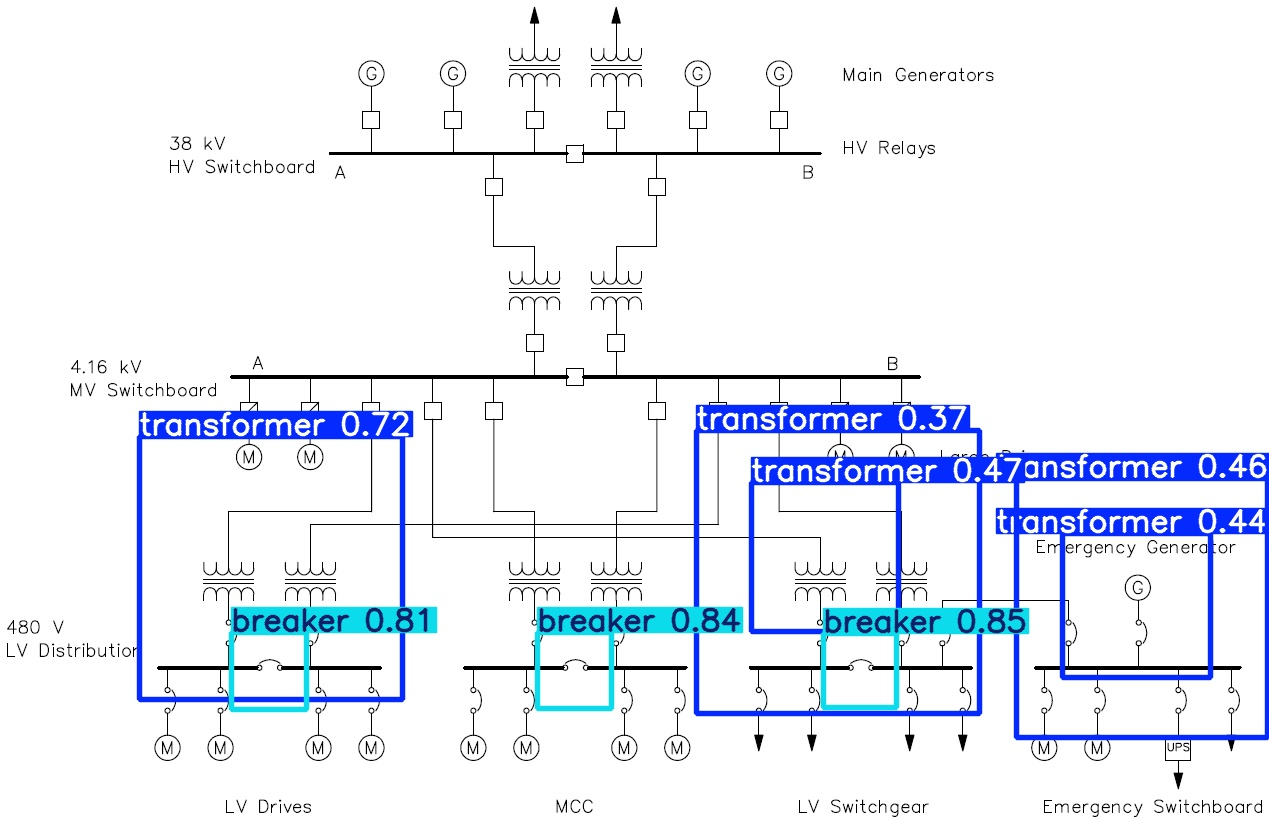

In [ ]:
from pathlib import Path
from PIL import Image
import os, math
from IPython.display import Image as DispImage, display

# Settings
src = Path("/content/One-Line-Sample.png")   # change if needed
tile_w = tile_h = 1280
stride_w = stride_h = 1280
conf = 0.35
iou = 0.5

# Make temp tile folder
tile_dir = Path("/content/tiles/images")
tile_dir.mkdir(parents=True, exist_ok=True)

# Tile the image
img = Image.open(src).convert("RGB")
W, H = img.size
count = 0
for y in range(0, H, stride_h):
    for x in range(0, W, stride_w):
        box = (x, y, min(x + tile_w, W), min(y + tile_h, H))
        tile = img.crop(box)
        tile_path = tile_dir / f"tile_{count:03d}.png"
        tile.save(tile_path)
        count += 1

print(f"Tiled into {count} images at {tile_dir}")

# Predict on tiles
pred = model.predict(
    source=str(tile_dir),
    imgsz=tile_w,
    conf=conf,
    iou=iou,
    save=True,
    save_txt=True,
    max_det=50,
    project="/content/runs/detect",
    name="predict_tiled_inline",
)
print(pred)

# View a predicted tile
pred_dir = Path("/content/runs/detect/predict_tiled_inline")
files = sorted(f for f in os.listdir(pred_dir) if f.lower().endswith((".png", ".jpg", ".jpeg")))
print("sample files:", files[:5])
if files:
    display(DispImage(filename=pred_dir / files[0]))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
